# Read in raw politifact stories, filter for relevant stories

Filter links:
 - twitter or blog
 - between 2021-06-01 and 2023-12-20 
 - truth value in ['pants-fire', 'false', 'mostly-false']
 - health cat in CATEGORIES = ['abortion', 'autism', 'coronavirus', 'drugs', 'disability', 'health-care', 'health-check', 'public-health']

In [6]:
import ast
import pandas as pd 
import numpy as np 
from datetime import datetime 

START_DATE = '2021-06-01'
END_DATE = '2023-12-21'

CATEGORIES = ['abortion', 'autism', 'coronavirus', 'drugs', 'disability', 'health-care', 'health-check', 'public-health']
TRUTH_VALUES = ['pants-fire', 'false', 'mostly-false']


def is_twitter(desc):
    try:
        desc = desc.lower()
        if "twitter" in desc or "tweet" in desc or "post on x" in desc or "x-post" in desc or "x post" in desc or "en x" in desc:
            return 1
        else:
            return 0
    except Exception as e:
        print(e)
        return np.NaN
    

def is_blog(desc):
    try:
        desc = desc.lower()
        if "in a blog" in desc or "bloggers" in desc:
            return 1
        else:
            return 0
    except Exception as e:
        print(e)
        return np.NaN
    
def is_valid_category(x, categories):
    x = [i.lower() for i in x]
    if len(set(x).intersection(set(categories))) > 0:
        return True
    else:
        return False
    
def safe_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except:
        return s  
    
input_fn = "raw_pf_links_2023-12-22__10_31_08.csv"
output_fn = "filtered_tweets.csv"


df = pd.read_csv(input_fn)

# Filtered df
df['tags'] = df['tags'].apply(lambda x: safe_literal_eval(x))
df['is_twitter'] = df['raw_desc'].apply(lambda x: is_twitter(x))
df['is_blog_desc'] = df['raw_desc'].apply(lambda x: is_blog(x))
df['is_blog_cat'] = df['type'].apply(lambda x: 1 if x=="Bloggers" else 0)
df['is_blog'] = np.maximum(df['is_blog_desc'], df['is_blog_cat'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')
filtered_df = df[(df['date'] >= START_DATE) & (df['date'] <= END_DATE)]
filtered_df = filtered_df[filtered_df['tags'].apply(lambda x: is_valid_category(x, CATEGORIES))]
filtered_df = filtered_df.query("truth_value in @TRUTH_VALUES")
filtered_df = filtered_df.query("is_twitter==1|is_blog==1")
filtered_df.to_csv(f"raw_{output_fn}")

# One df for manual validation 
filtered_df['annotated_column'] = ''
filtered_df['raw_url'] = ''
filtered_df['twitter_handle'] = ''
filtered_df['n_followers'] = ''
filtered_df.to_csv(f"to_annotate_{output_fn}")

# Now manually annotate and rename "annotated_{output_fn}" so don't write over

# Read in annotated df

In [170]:
adf = pd.read_csv("annotated_filtered_tweets.csv")
adf['date'] = pd.to_datetime(adf['date'], format='%m/%d/%y', errors='coerce')
adf['elected_rep'] = adf['annotated_column'].apply(lambda x: 1 if "elected_rep" in str(x) else 0)
hardcoded_current_date = pd.to_datetime('2023-12-22')
adf['days_since_tweet'] = (hardcoded_current_date - adf['date']).dt.days

print("BEFORE FILTERING")
print("Number of stories", len(adf))
print("Number of spreaders", adf['twitter_handle'].nunique())
print("Number of politicans or elected reps", adf['elected_rep'].sum())


# Filter for things like account suspended
print("FILTERING FOR AVAILABLE HANDLES AND NO REPS")
adf = adf.query("problem==0")
adf = adf[adf['twitter_handle'].notna()]
adf = adf.query("elected_rep==0")
print("Number of stories", len(adf))
print("Number of spreaders", adf['twitter_handle'].nunique())


# Group data 
new_df = adf.groupby('twitter_handle').agg(
    n_followers=('n_followers', 'max'), 
    count=('twitter_handle', 'count'), 
    last_story = ("date", "max"),
    days_ago = ("days_since_tweet", "min")
).reset_index()

new_df['months_ago'] = new_df['days_ago']/30
new_df['log_followers'] = np.log(new_df['n_followers'])

BEFORE FILTERING
Number of stories 89
Number of spreaders 49
Number of politicans or elected reps 9
FILTERING FOR AVAILABLE HANDLES AND NO REPS
Number of stories 52
Number of spreaders 38


# Create some indexes

In [171]:
for var in ['log_followers', 'last_story', 'count']:
    new_df[f'rank_{var}'] = new_df[var].rank(ascending=True)

new_df['rank_neutral_emph'] = (new_df['rank_log_followers'] + new_df['rank_last_story'] + new_df['rank_count'])/3
new_df['rank_count_emph'] = 0.15*new_df['rank_log_followers'] + 0.15*new_df['rank_last_story'] + 0.7*new_df['rank_count']
new_df['rank_follower_emph'] = 0.7*new_df['rank_log_followers'] + 0.15*new_df['rank_last_story'] + 0.15*new_df['rank_count']
new_df['rank_recent_emph'] = 0.7*new_df['rank_log_followers'] + 0.15*new_df['rank_last_story'] + 0.15*new_df['rank_count']

new_df[[x for x in new_df.columns if "_emph" in x]].corr()

,rank_neutral_emph,rank_count_emph,rank_follower_emph,rank_recent_emph
rank_neutral_emph,1.000000,0.867121,0.796956,0.796956
rank_count_emph,0.867121,1.000000,0.584407,0.584407
rank_follower_emph,0.796956,0.584407,1.000000,1.000000
rank_recent_emph,0.796956,0.584407,1.000000,1.000000


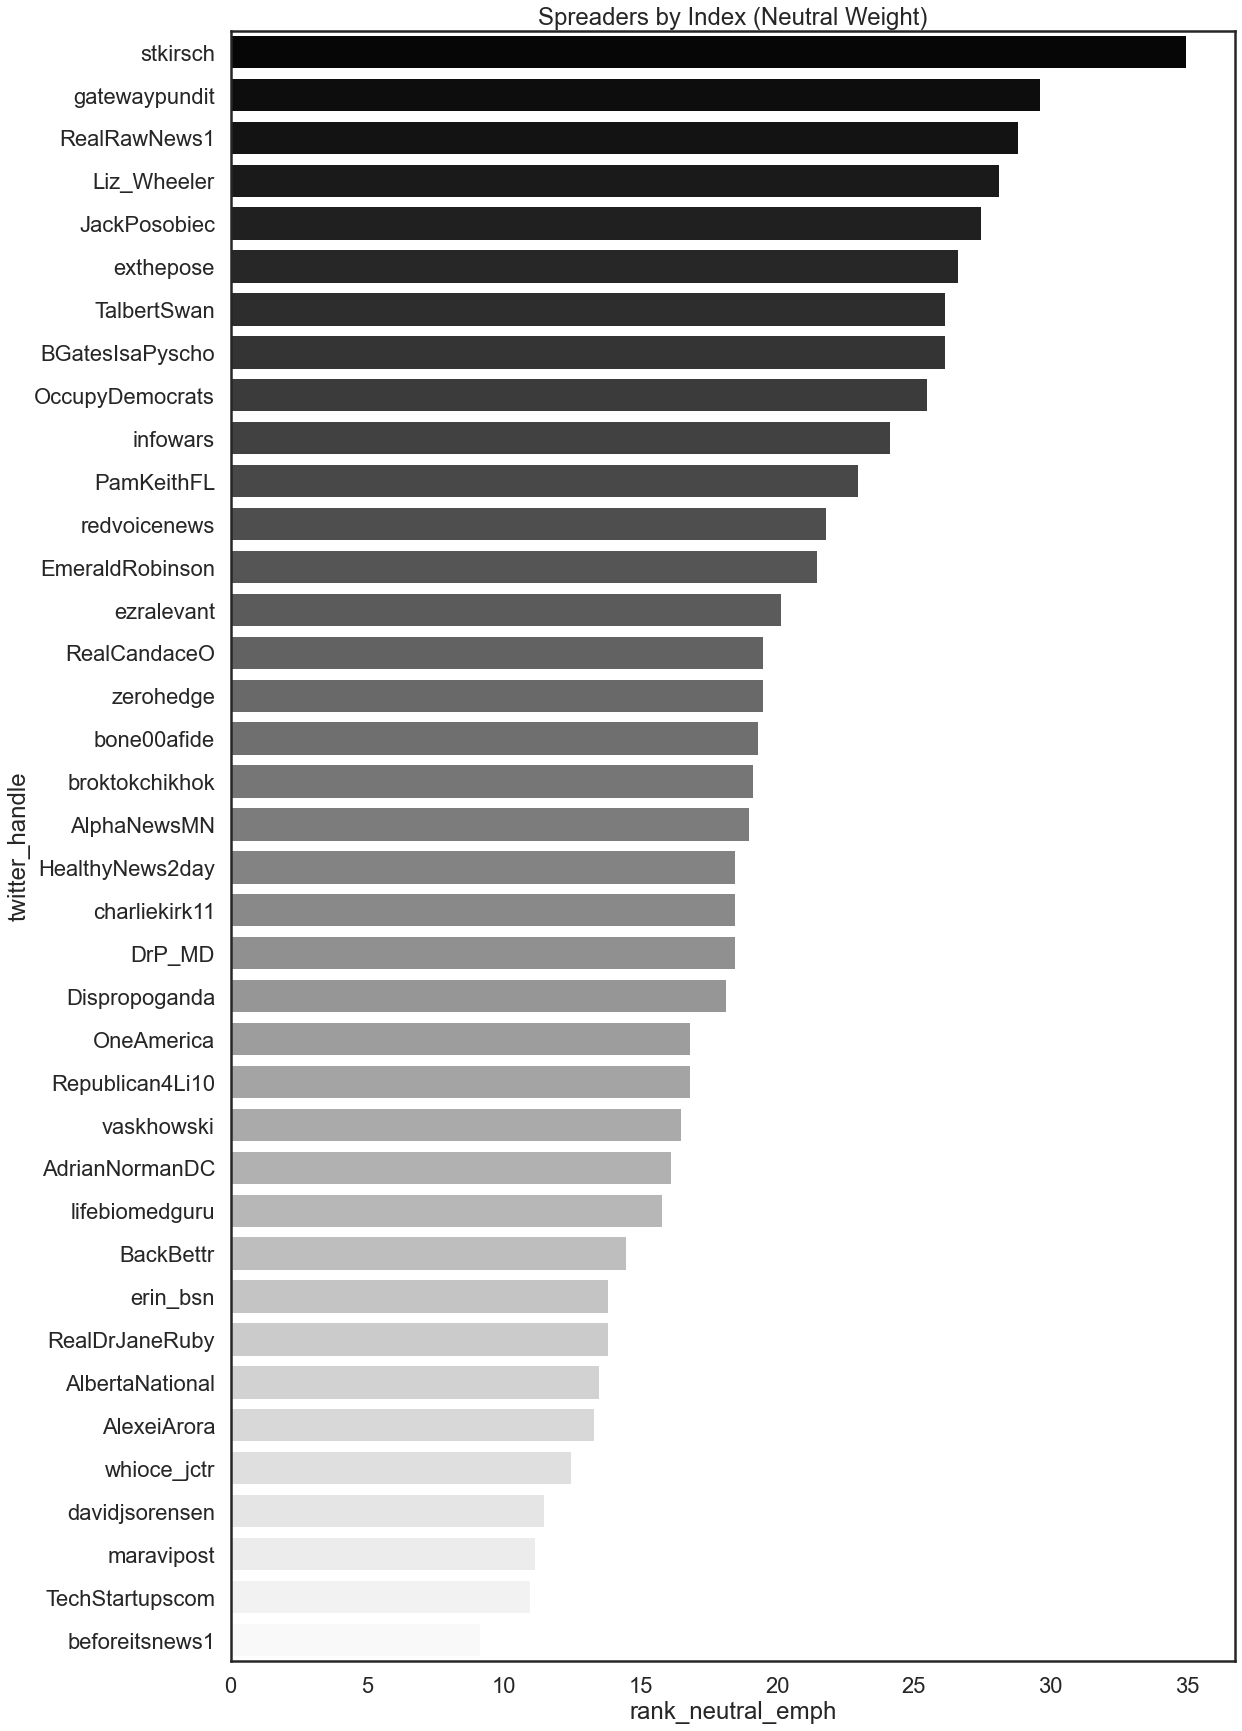

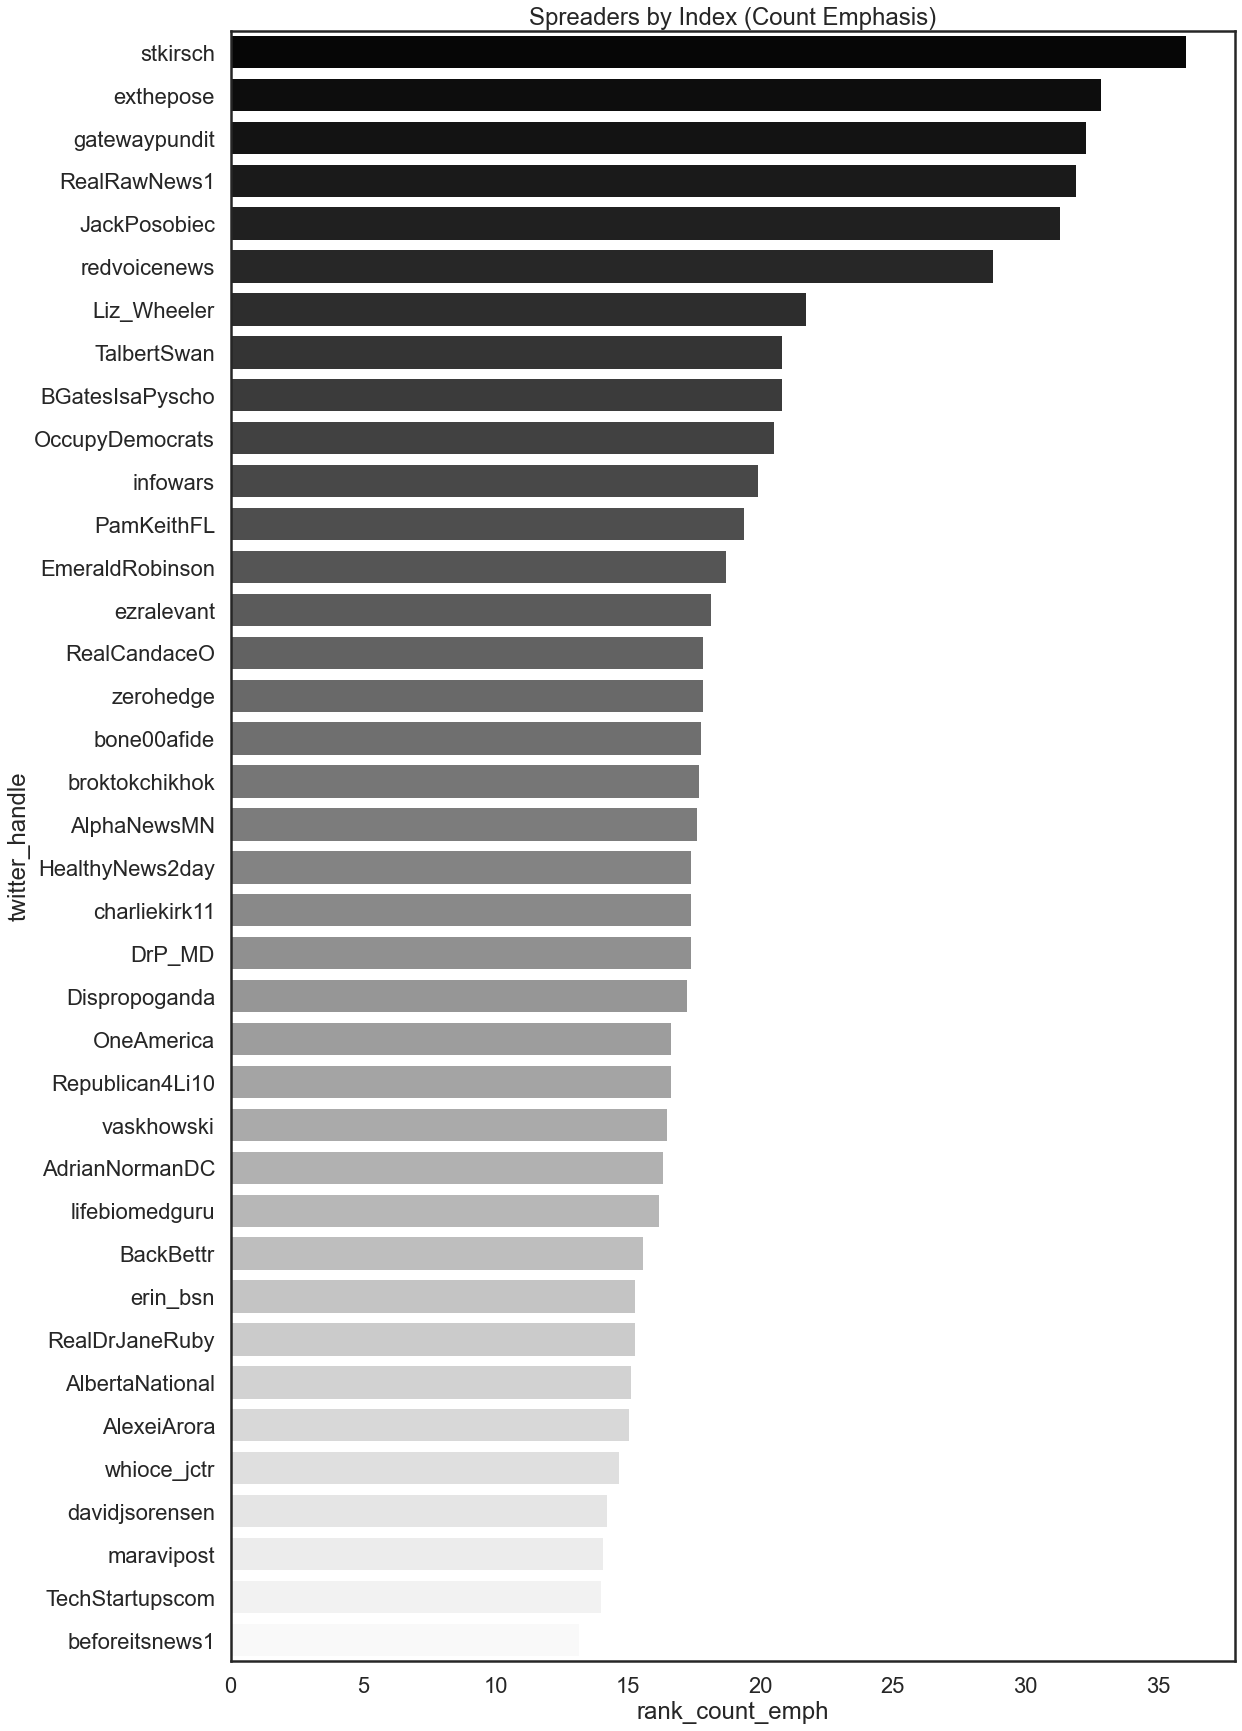

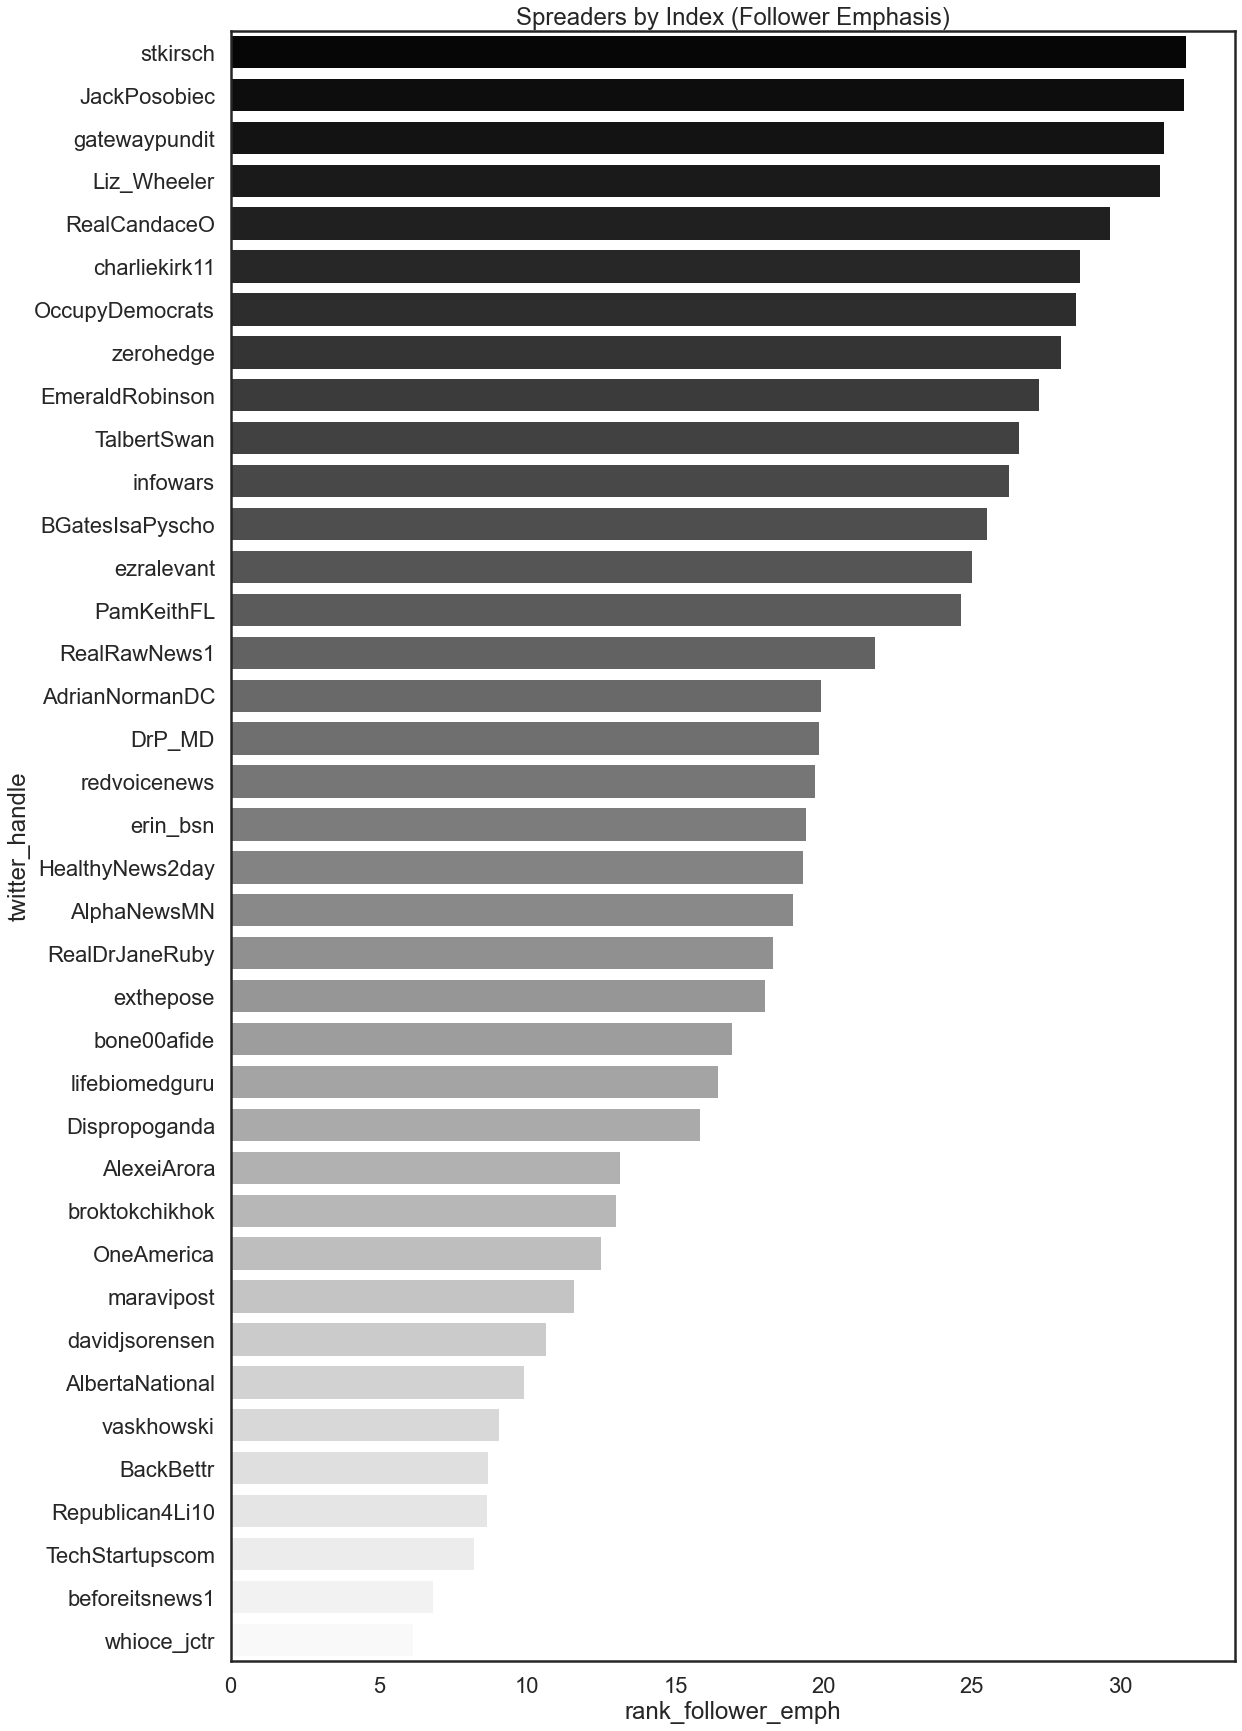

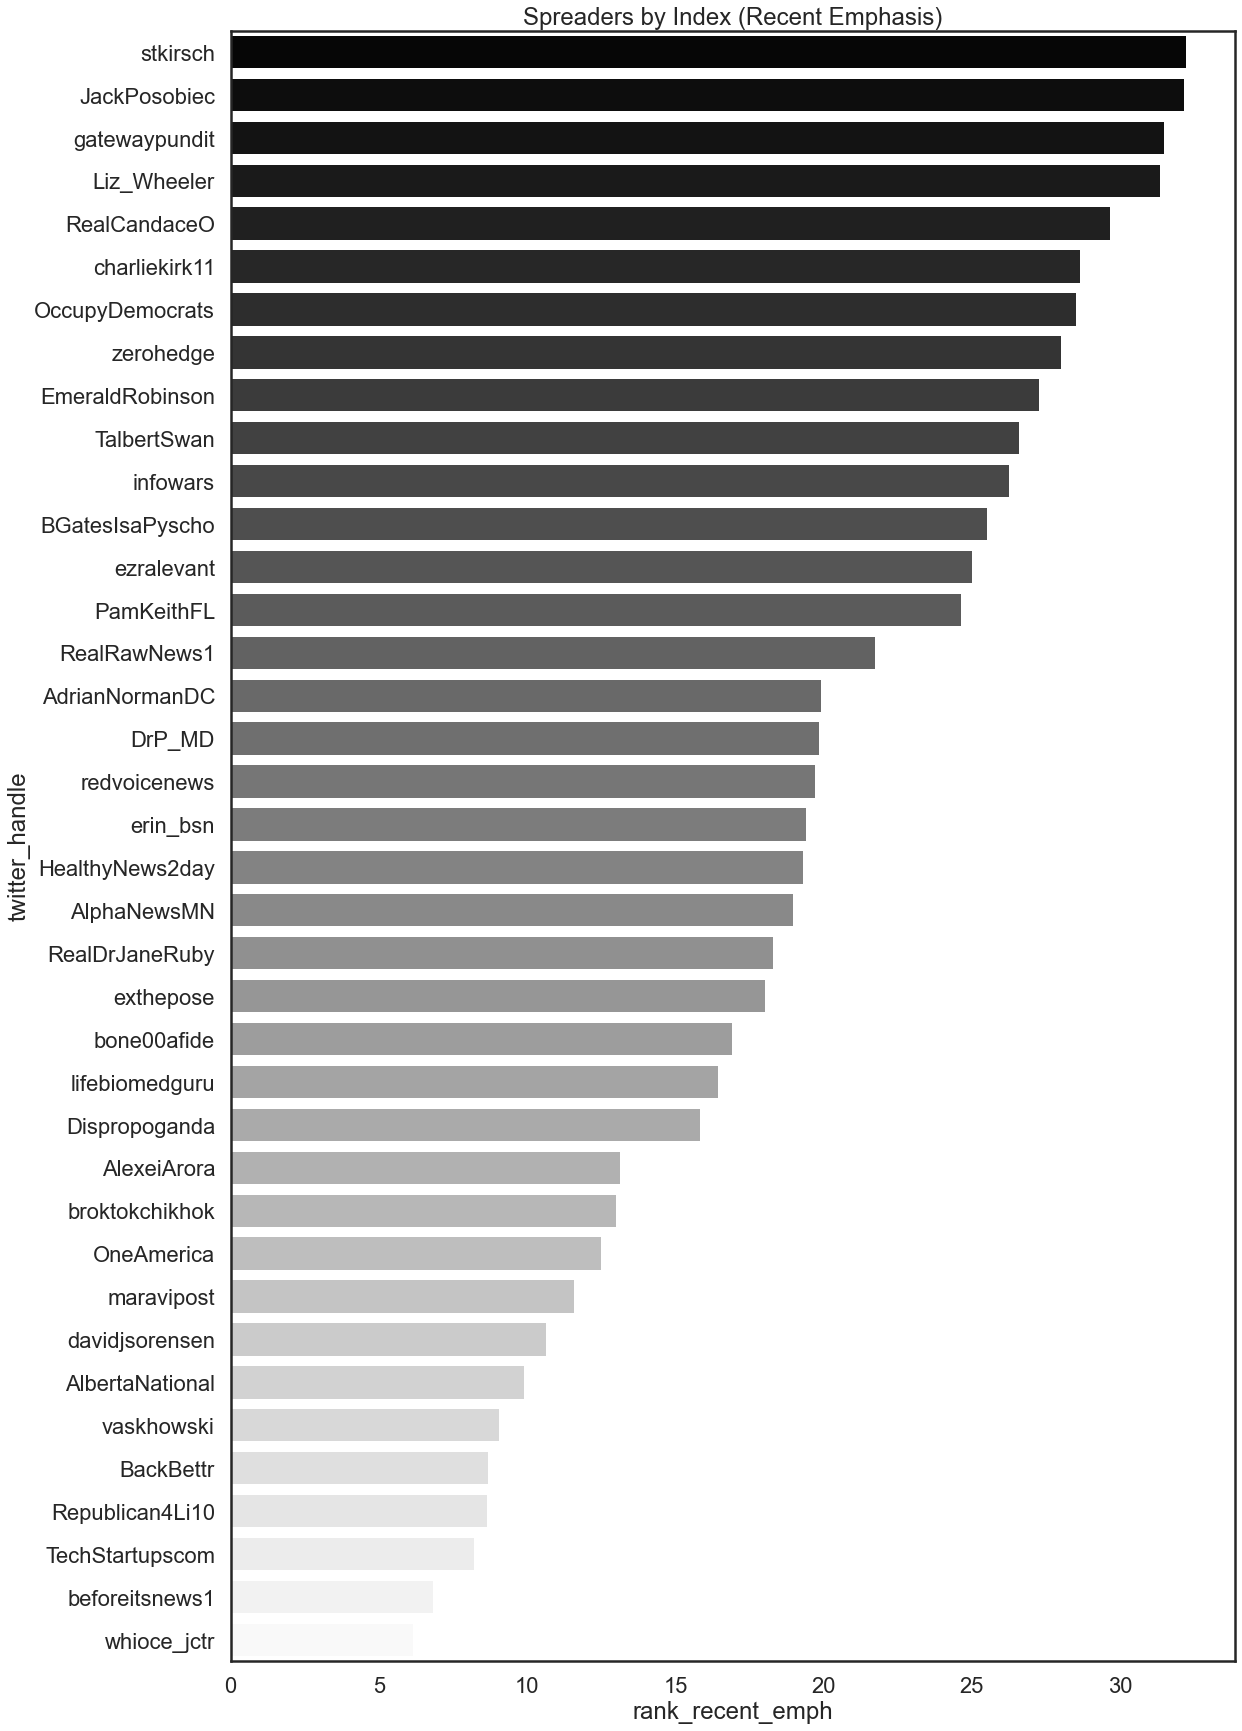

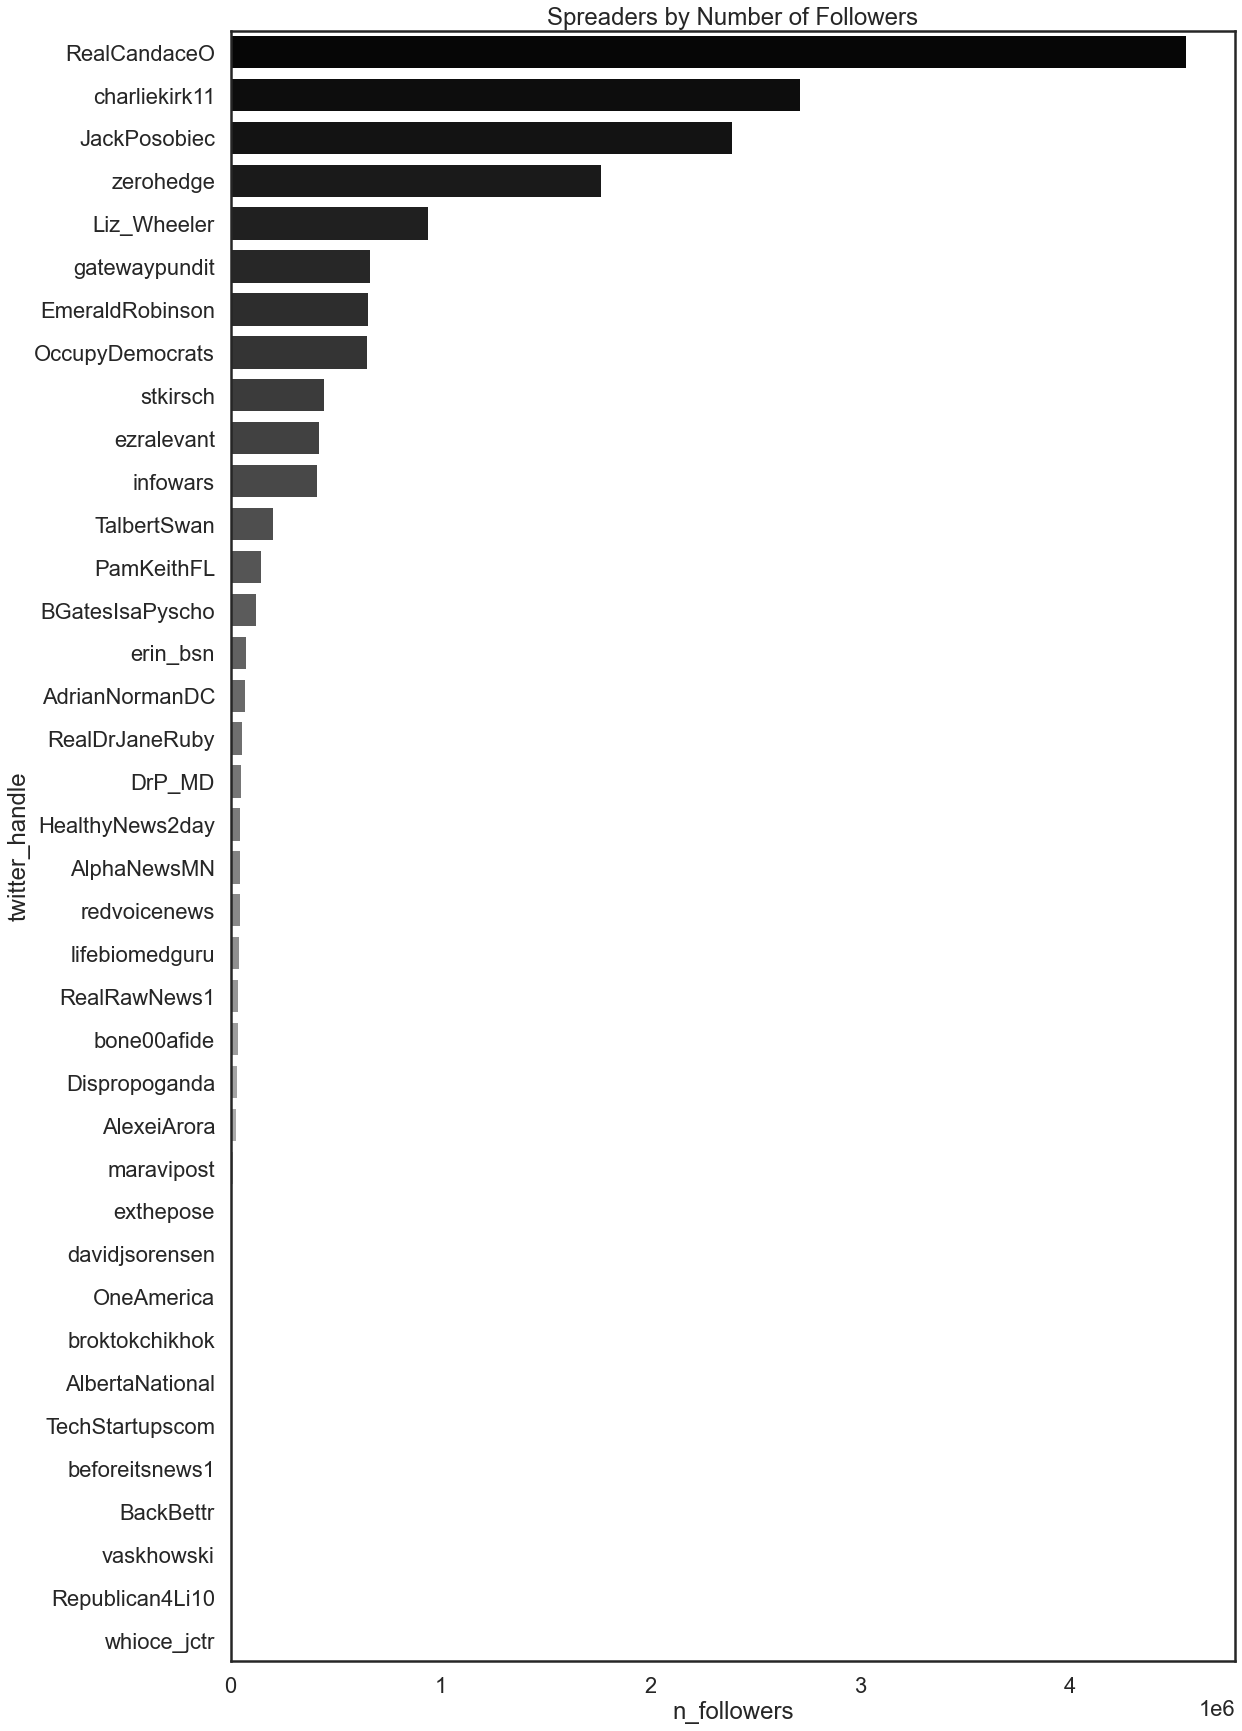

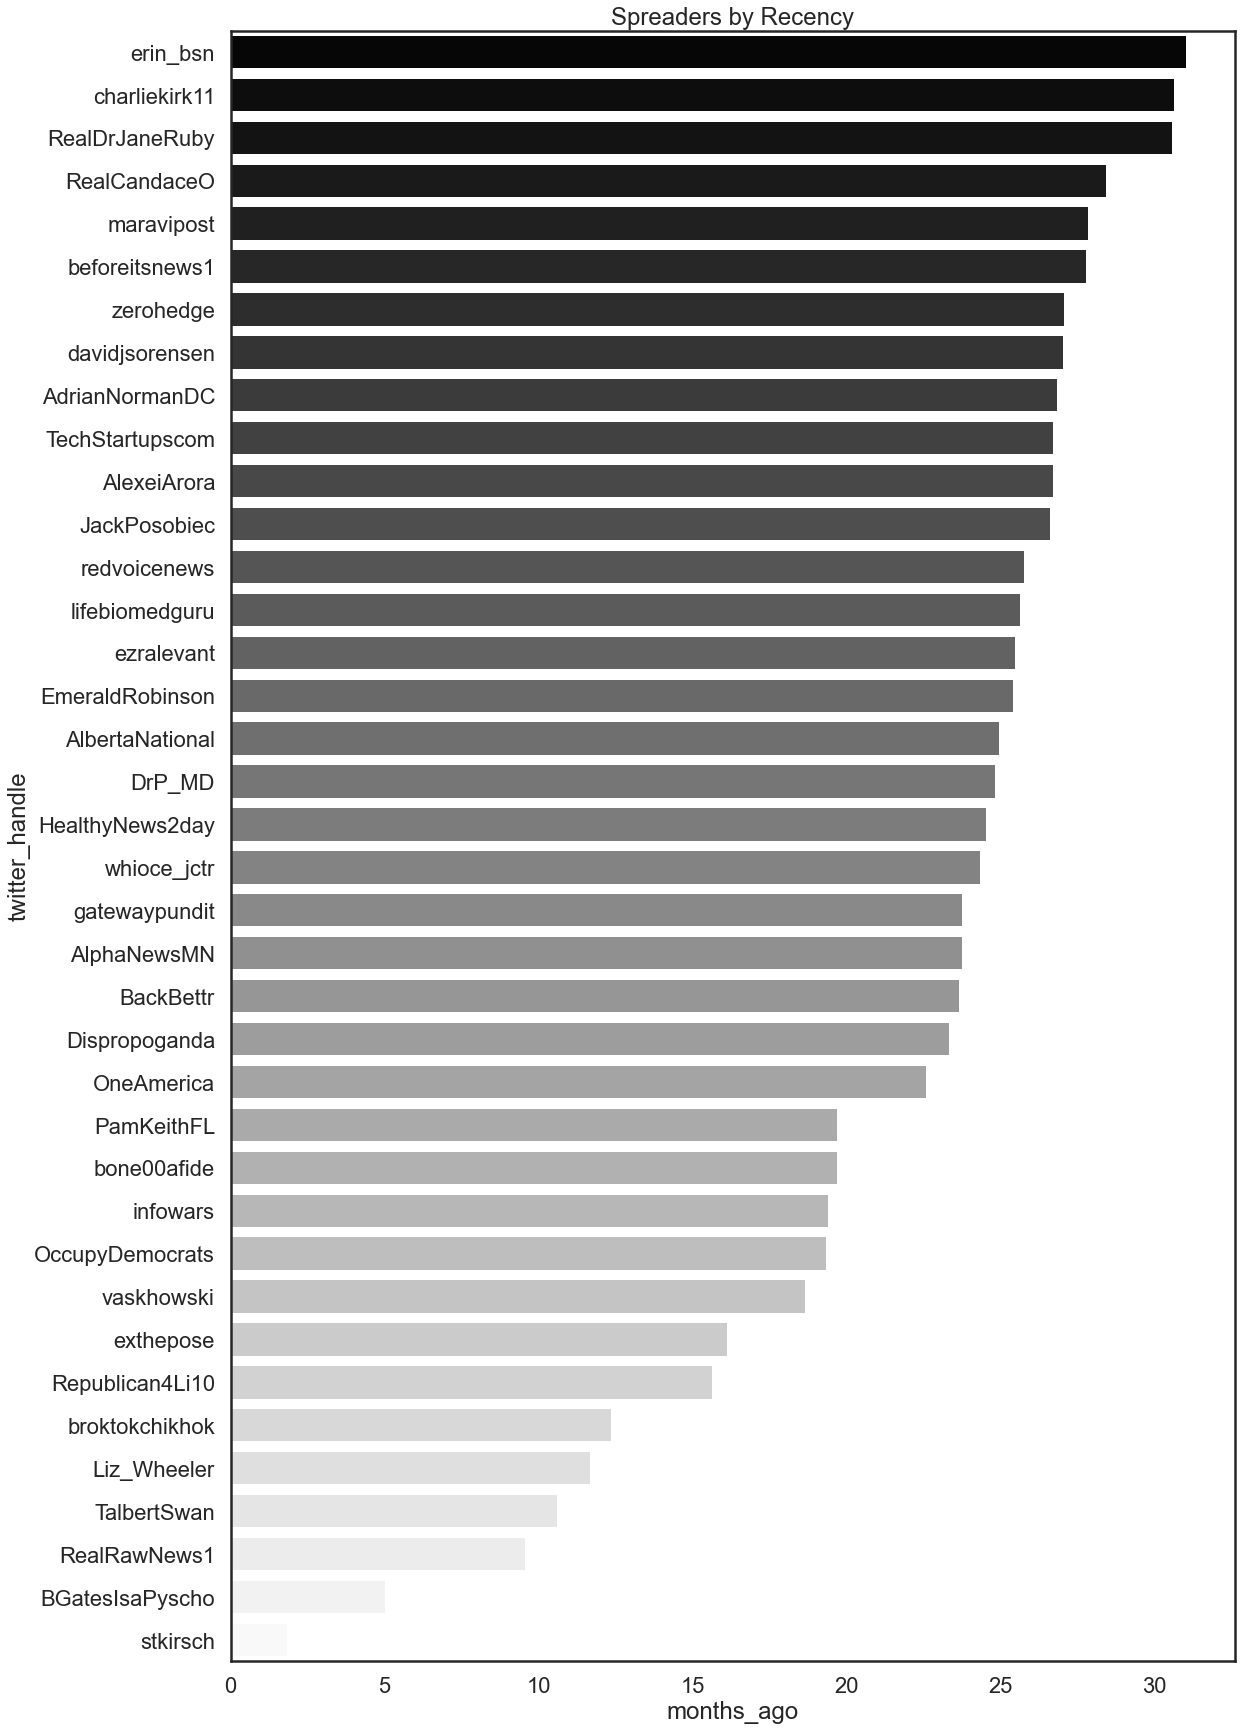

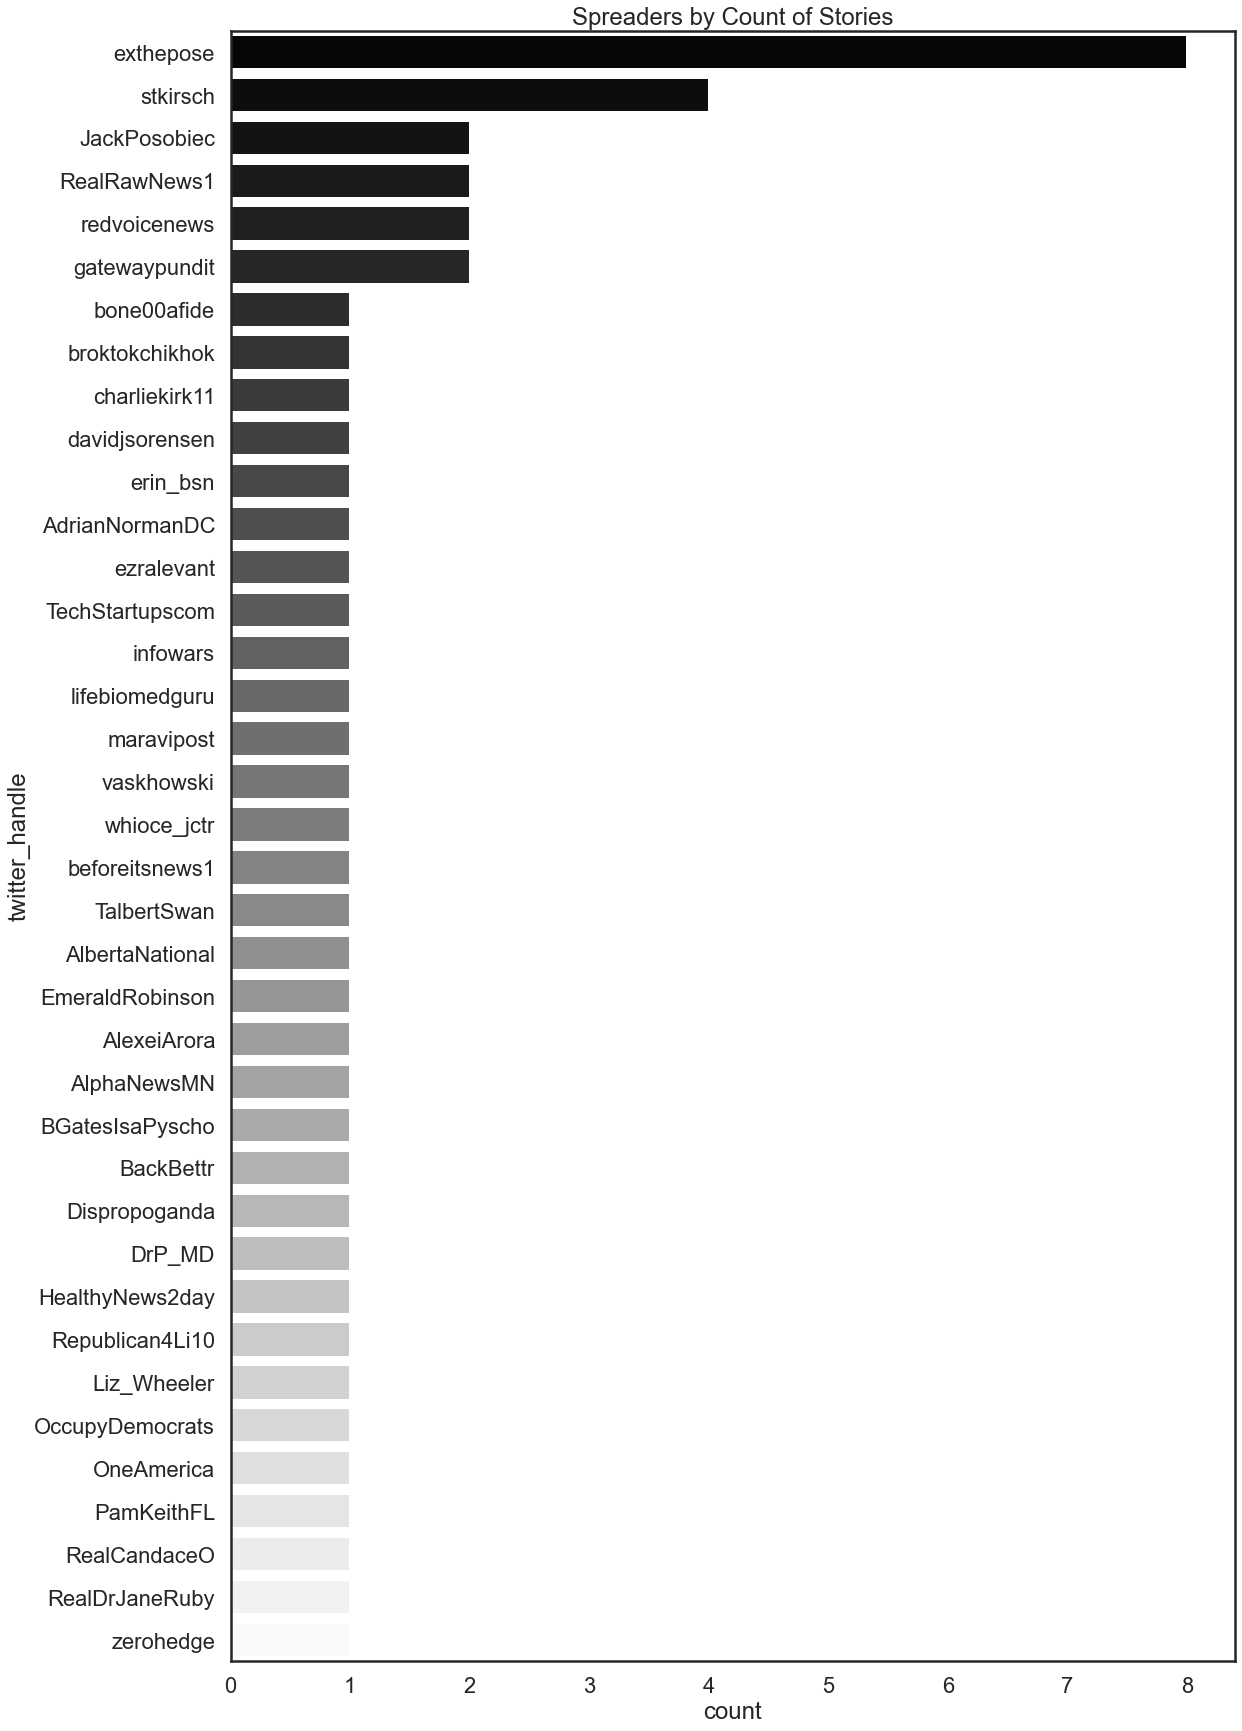

In [179]:
sns.set(context="poster", style='white')

def create_bar_plot(df, title, y_label, x_label):
    sorted_df = df.sort_values(by=x_label, ascending=False)
    plt.figure(figsize=(18, 30))
    plt.title(title)
    sns.barplot(data=sorted_df, y=y_label, x=x_label, palette='binary_r')
    plt.show()

plot_details = {
    "Spreaders by Index (Neutral Weight)": 'rank_neutral_emph',
    "Spreaders by Index (Count Emphasis)": 'rank_count_emph',
    "Spreaders by Index (Follower Emphasis)": 'rank_follower_emph',
    "Spreaders by Index (Recent Emphasis)": 'rank_recent_emph',
    "Spreaders by Number of Followers": 'n_followers',
    "Spreaders by Recency": 'months_ago',
    "Spreaders by Count of Stories": 'count'
}

for title, sort_column in plot_details.items():
    create_bar_plot(new_df, title, 'twitter_handle', sort_column)  
    

In [176]:
adf[['date', 'title', 'url', 'tags', 'annotated_column', 'raw_url', 'twitter_handle', 'n_followers', 'date']]

,date,title,url,tags,annotated_column,raw_url,twitter_handle,n_followers,date
1,2023-10-27,“The FDA is required to take the COVID vaccine...,https://www.politifact.com/factchecks/2023/oct...,"['Science', 'Coronavirus', 'Steve Kirsch']",NaN,https://twitter.com/stkirsch/status/1715820838...,stkirsch,450066.0,2023-10-27
2,2023-08-14,"COVID-19 vaccines have killed 676,000 Americans.",https://www.politifact.com/factchecks/2023/aug...,"['Public Health', 'Facebook Fact-checks', 'Cor...",NaN,https://kirschsubstack.com/p/vaers-data-is-cry...,stkirsch,450066.0,2023-08-14
3,2023-07-24,ESPN soccer analyst Shaka Hislop collapsed on ...,https://www.politifact.com/factchecks/2023/jul...,"['Facebook Fact-checks', 'Coronavirus', 'X pos...",NaN,https://twitter.com/BGatesIsaPyscho/status/168...,BGatesIsaPyscho,124740.0,2023-07-24
4,2023-03-09,Vladimir Putin “orders destruction of all COVI...,https://www.politifact.com/factchecks/2023/mar...,"['Facebook Fact-checks', 'Coronavirus', 'Russi...",ensure matched accnt,https://realrawnews.com/2023/03/putin-orders-d...,RealRawNews1,41247.0,2023-03-09
6,2023-02-06,Diamond and Silk pundit died from COVID-19,https://www.politifact.com/factchecks/2023/feb...,"['North Carolina', 'Coronavirus', 'X posts']",NaN,https://twitter.com/TalbertSwan/status/1612690...,TalbertSwan,208282.0,2023-02-06
7,2023-01-05,"There have been “1,598 athlete cardiac arrests...",https://www.politifact.com/factchecks/2023/jan...,"['Public Health', 'Sports', 'Facebook Fact-che...",NaN,https://twitter.com/Liz_Wheeler/status/1610309...,Liz_Wheeler,944794.0,2023-01-05
8,2022-12-15,Stephen Boss died because of the COVID-19 vacc...,https://www.politifact.com/factchecks/2022/dec...,"['Facebook Fact-checks', 'Coronavirus', 'X pos...",NaN,https://twitter.com/broktokchikhok/status/1603...,broktokchikhok,1289.0,2022-12-15
11,2022-09-08,Queen Elizabeth died because of the COVID-19 v...,https://www.politifact.com/factchecks/2022/sep...,"['Facebook Fact-checks', 'Coronavirus', 'X pos...",NaN,https://twitter.com/Republican4Li10/status/156...,Republican4Li10,50.0,2022-09-08
12,2022-08-24,"In England, “COVID-19 vaccinated children are ...",https://www.politifact.com/factchecks/2022/aug...,"['Children', 'Facebook Fact-checks', 'Coronavi...",NaN,https://expose-news.com/2022/07/27/uk-gov-vacc...,exthepose,7760.0,2022-08-24
14,2022-07-29,“‘Monkeypox’ is only circulating in countries ...,https://www.politifact.com/factchecks/2022/jul...,"['Public Health', 'Science', 'Facebook Fact-ch...",NaN,https://expose-news.com/2022/07/24/monkeypox-p...,exthepose,7760.0,2022-07-29
